<a href="https://colab.research.google.com/github/syedanida/Decision-Trees-and-Ensemble/blob/main/adaBoost_fromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Create synthetic dataset (binary classification)
X, y = make_classification(n_samples=500, n_features=20, n_informative=2, n_classes=2, random_state=42)
y = 2*y - 1  # Convert to {-1, 1} labels

In [3]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [4]:
# Decision Stump (weak learner)
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = None
        self.alpha = None

    def fit(self, X, y, sample_weight):
        m, n = X.shape
        min_error = float('inf')

        # Loop over all features to find the best feature to split on
        for feature_index in range(n):
            thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                # Predict labels based on the current threshold
                prediction = np.ones_like(y)
                prediction[X[:, feature_index] < threshold] = -1

                # Calculate the weighted error
                error = np.sum(sample_weight * (prediction != y))

                # Update the best split if the current error is smaller
                if error < min_error:
                    min_error = error
                    self.feature_index = feature_index
                    self.threshold = threshold
                    self.polarity = 1 if np.sum(sample_weight * (prediction != y)) <= min_error else -1
                    self.alpha = 0.5 * np.log((1 - min_error) / (min_error + 1e-10))

    def predict(self, X):
        prediction = np.ones(X.shape[0])
        prediction[X[:, self.feature_index] < self.threshold] = -1
        return prediction * self.polarity

In [5]:
# AdaBoost Classifier
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        m, n = X.shape
        sample_weight = np.ones(m) / m  # Initialize sample weights equally

        for _ in range(self.n_estimators):
            model = DecisionStump()
            model.fit(X, y, sample_weight)
            predictions = model.predict(X)

            # Compute the error and model weight (alpha)
            error = np.sum(sample_weight * (predictions != y)) / np.sum(sample_weight)
            if error > 0.5:
                continue  # Skip this model if error is too high (weak learner)

            self.models.append(model)
            self.alphas.append(model.alpha)

            # Update the sample weights for the next round
            sample_weight *= np.exp(-model.alpha * y * predictions)
            sample_weight /= np.sum(sample_weight)  # Normalize to sum to 1

    def predict(self, X):
        # Weighted sum of predictions from all models
        predictions = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            predictions += alpha * model.predict(X)
        return np.sign(predictions)

In [6]:
# Train AdaBoost
ada_boost = AdaBoost(n_estimators=50)
ada_boost.fit(X_train, y_train)

In [7]:
# Test the model
y_pred = ada_boost.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 88.67%


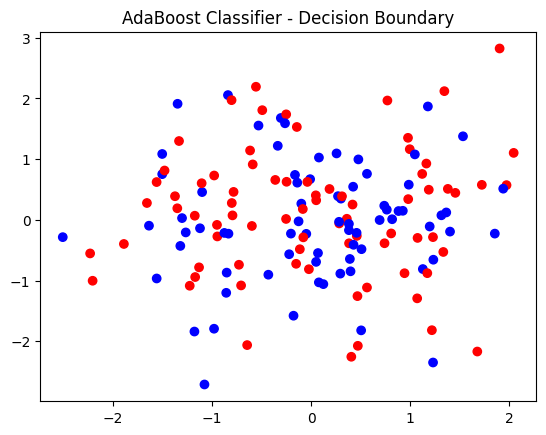

In [8]:
# Plotting decision boundary (optional, works well for 2D data)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='bwr', marker='o')
plt.title("AdaBoost Classifier - Decision Boundary")
plt.show()